In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import words as vocab_words
from functools import partial
from collections.abc import Iterable
from ast import literal_eval
import string
import os 
import enchant
import numpy as np
import gc
stop_words = stopwords.words('english')
dictionary = enchant.Dict("en_US")

ModuleNotFoundError: No module named 'nltk'

In [ ]:
# DATAPREPROCESSING HYPERPARAMETERS
RAW_DATASET = "./raw_dataset/twcs/twcs.csv"
PROCESSED_DATASET = "./processed_dataset"
CORES = cpu_count()
DATA_CHUNK = 150

## Text Data Preprocessing

In [ ]:
class Preprocessing:
    def __init__(self, df):
        self.df = df
    
    def clean_up(self, interest_columns):
        # Check if any entry in any of the columns is Null,NaN and NaT.
        print("Check for Null, NaN, NaT ...")
        for col in interest_columns:
            if self.df[col].isnull().values.any():
                print(f"Values missing in the column : {col}")
                print(f"Elements to be dropped from the from the column : {col}")
            else:
                print(f"{col} is clean")
        
        self.df.dropna()
        print("\nCheck for duplicate entries ...")
        for col in interest_columns:
            if self.df[col].duplicated().any():
                print(f"Duplicate values in the column : {col}")
                print("Dropping duplicates")
                self.df[col].drop_duplicates()
            else:
                print(f"{col} is clean")

    def split_df(self, split_ratio=[0.6,0.2]):
        # Split the df into train, val and test sets
        # sets = [train, val and test]
        sets = np.split(self.df.sample(frac=1), [int(split_ratio[0]*len(self.df)), int((1-split_ratio[1])*len(self.df))])
        del self.df
        return sets

    # To have a generalized column dropping, it can be generalized by passing drop column as an argument.
    def drop_cols(self, sets, drop_columns, index=None):
        processed_sets = []
        for sub_set in sets:
            sub_set = sub_set.drop(columns=drop_columns)
            if index is not None:
                sub_set = sub_set.set_index(index)
            processed_sets.append(sub_set)
        return processed_sets

    # Tokenize and Process the text column
    def tokenize_tweets(self, text_column, sub_set):
        sub_set['Processed_text'] = sub_set[text_column].apply(lambda tweet: word_tokenize(tweet)).apply(lambda tweet : [re.sub('[0-9]', '', i) for i in tweet])
        sub_set['Processed_text'] = sub_set['Processed_text'].apply(lambda tweet: [re.sub('(?<=[a-z])\'(?=[a-z])', '', i) for i in tweet])
        sub_set['Processed_text'] = sub_set['Processed_text'].apply(lambda tweet: [word for word in tweet if len(word) > 0])
        sub_set['Processed_text'] = sub_set['Processed_text'].apply(lambda tweet: [word for word in tweet if dictionary.check(word)])
        sub_set['Processed_text'] = sub_set['Processed_text'].apply(lambda tweet :[word.lower() for word in tweet if word not in string.punctuation])
        sub_set['Processed_text'] = sub_set["Processed_text"].apply(lambda tokens : [token for token in tokens if not isinstance(token, (int, float))])
        sub_set = sub_set[sub_set["Processed_text"].str.len()>1]
        return sub_set
    
# Parallelized multiprocessing of the dataframes
def parallelized_process(df_set, func, col_name=None, num_cores=1):
    final_set = []
    process_id = 0
    for st in df_set:
        divide_df = np.array_split(st, num_cores)
        if col_name is None:
            pool_obj= Pool(num_cores)
            st_join = pd.concat(pool_obj.map(func, divide_df))
            pool_obj.close()
            pool_obj.join()
        else:
            operate_func = partial(func, col_name)
            pool_obj= Pool(num_cores)
            st_join = pd.concat(pool_obj.map(operate_func, divide_df))
            pool_obj.close()
            pool_obj.join()
        final_set.append(st_join)
    
    return final_set
        

In [ ]:
"""
* To enable switch the change value to 1 in the if condition
* The Preprocessing of the dataset
* Setting values to the below parameters require a basic understanding of the dataset, which columns are relevant
* Considering the use-case of sentiment Analysis, The preprocessing component is dataset agnostic
"""
# Configuration Parameters
INTEREST_COLS = ["tweet_id", "text"]
DROP_COLS = ["author_id", "inbound", "created_at", "response_tweet_id", "in_response_to_tweet_id"]
TEXT_COL = "text"


if(0):
    df_chunks = pd.read_csv(RAW_DATASET, delimiter=",", encoding="",chunksize= 10000)
    train_list = []
    val_list = []
    test_list = []
    for i, chunk in enumerate(df_chunks):
        print(f"\n\nProcessing chunk : {i+1} ...")
        preprocess = Preprocessing(chunk)
        preprocess.clean_up(INTEREST_COLS)
        sets = preprocess.split_df()
        train, val, test = preprocess.drop_cols(sets, DROP_COLS)
        train, val = parallelized_process([train, val], preprocess.tokenize_tweets, col_name=TEXT_COL, num_cores=CORES)
        train_list.append(train)
        val_list.append(val)
        test_list.append(test)

    # Create processed sets
    processed_sets = [pd.concat(train_list), pd.concat(val_list), pd.concat(test_list)]
    # Store to the system
    [st.to_csv(os.path.join(PROCESSED_DATASET, f"{name}.csv")) for name, st in zip(["train_set", "val_set", "test_set"], processed_sets)]

    



# Sentiment Model 

### Why Transformer based architecture chosen ?

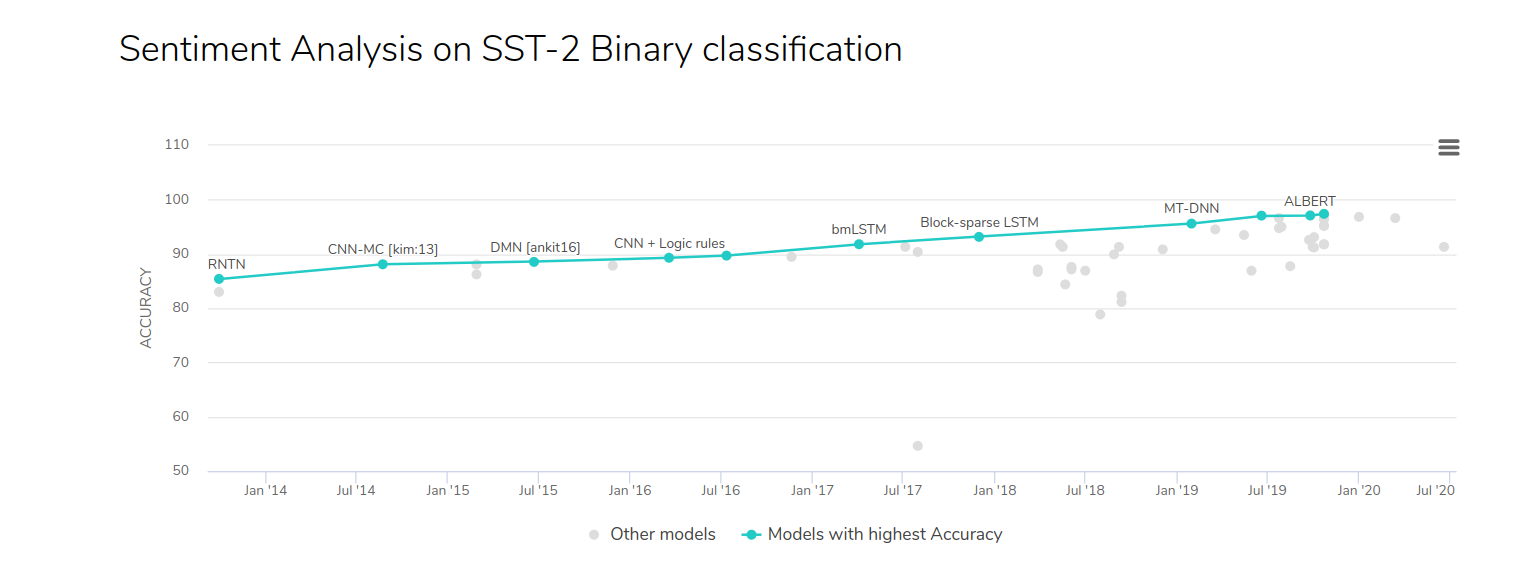

### Evaluation dimension

* The current state of the art network on Stanford Standard Treebank(SST-2) is ALBERT which is self-supervised learnt language representation model based on Bidirectional Encoder Representation from Transformer.

paper link : https://arxiv.org/pdf/1909.11942.pdf

github repo : https://github.com/huggingface/transformers (open sourced, under Apache License 2.0, a python pip package transformers)

* The model achieves 97.4% Accuracy on SST-2 and therefore a right candidate to be transfer learnt or used for label generation for domain specific datasets.


### Algorithmic dimension

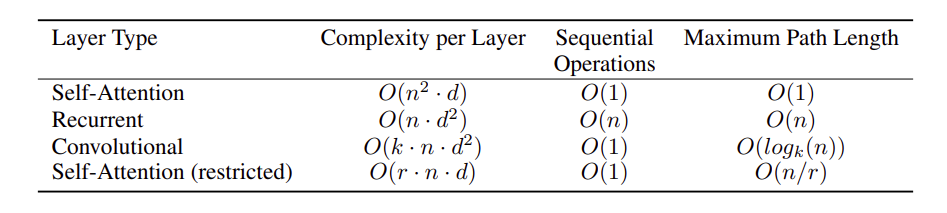

* A constant time sequential operation.

* Degree one polynomial vector dimension proportionlity for per layer complexity.

* Linear network propagation path length

* The core idea behind the model is the usage of the bidirectional attention mechanism to learn the dependencies between the latent vector representations.

* All vectors are fed to the network parallely rather sequentially, there is no sequential dependence and there is no backpropagation through time unlike RNNs.

* The attention mechanism allow connections between the hidden states (output vector) of each encoder and decoder, so that the target word is predicted based on a combination of vectors, rather than just the hidden state of the decoder, this mechanism gives the decoder access to all the hidden states of the encoder.

* A weighted hidden state tensor parameterized by the attention is fed to the decoder, to make prediction about the next vector state. There is no use of memory here, compared to the RNNs.

* Overall, transformer based architecture beats RNN, CNN based models on SST-2 by a huge margin, as seen in the first plot. The best RNN based accuracy on SST-2 achieved is 93.200 by Block-sparse LSTM while state of the art is 97.40%


In [ ]:
'''
* Generating label for the unlabelled tweets for training using the transformer based Bert model
* loading the train and validation sets in chunks, instantiating the transformer model and run a forward pass
over each tweet to generate prediction. There are two predictions:
    label : Positive / Negative 
    score : The probability, how strong/confident the label is. (0-1)
    For e.g. label = "Negative" and score = 0.9932239234 -> Strongly negative tweet

'''

from transformers import pipeline

def gen_sentiment(model, df_slice):
    for row in range(len(df_slice)):
        if type(df_slice.iloc[row, 3]) is not str:
            df_slice.iloc[row, 3] = str(df_slice.iloc[row, 3])
            df_slice.iloc[row, 3] = df_slice.iloc[row,3][1:-2]
        else:
            df_slice.iloc[row, 3] = df_slice.iloc[row,3][1:-2].replace("'", "").replace(",", "")
    list_tweets = [df_slice.iloc[row, 3] for row in range(len(df_slice))]
    df_slice['label'] = [predict["label"] for predict in model(list_tweets)]
    df_slice['score'] = [predict["score"] for predict in model(list_tweets)]
    df_slice["label"] = df_slice["label"].apply(lambda label: 0 if label == 'NEGATIVE' else 1 )
    df_slice = df_slice.drop(['Unnamed: 0', 'tweet_id', 'text'], axis=1)
    return df_slice

if(0):
    for st in ["train_set", "val_set"]:
        model = pipeline('sentiment-analysis', device=0)
        df_chunks = pd.read_csv(os.path.join(PROCESSED_DATASET, f"{st}.csv"), chunksize=DATA_CHUNK)
        df_list = []
        for i, chunk in enumerate(df_chunks):
            print(f"Processing chunk : {i+1} ...")
            curr_sentiments = gen_sentiment(model,chunk)
            df_list.append(curr_sentiments) 
            if (i+1)% 800 ==0:
                df_save = pd.concat(df_list)
                df_save.to_csv(os.path.join(PROCESSED_DATASET, f"{st}_labels_{i+1}.csv"), index=False)
        df_save = pd.concat(df_list)
        df_save.to_csv(os.path.join(PROCESSED_DATASET, f"{st}_labels.csv"), index=False)

In [1]:
### Check the Class distribution of the scores

'''
Each class number of datapoints. Split the labels into 5 reasons.
Strong negative 1.0 to 0.5 and "NEGATIVE"
Weak negative 0.5 to 0.1 and "NEGATIVE"
neutral 0.1 - 0 (Negative and Positive both)
Weak positive -> 0.1 to 0.5 and Positive
'''

for st in ["train_set", "val_set"]:
    
    df_labels = pd.read_csv(os.path.join(PROCESSED_DATASET, f"{st}_labels.csv"))
    
    neut_ids = (df_labels["score"] > 0.0) & (df_labels["score"]<=0.1)
    weak_pos_ids = (df_labels["score"] > 0.1) & (df_labels["score"]<=0.5) & (df_labels["label"] == 1)
    strong_pos_ids = (df_labels["score"] > 0.5) & (df_labels["score"]<=1) & (df_labels["label"] == 1)
    weak_neg_ids = (df_labels["score"] > 0.1) & (df_labels["score"]<=0.5) & (df_labels["label"]== 0)
    strong_neg_ids = (df_labels["score"] > 0.5) & (df_labels["score"]<=1) & (df_labels["label"]== 0)
    
    print(f"{st} neutral tweets : {len(df_labels[neut_ids])}")
    print(f"{st} weak positive Tweets : {len(df_labels[weak_pos_ids])}")
    print(f"{st} strong positive Tweets : {len(df_labels[strong_pos_ids])}")
    print(f"{st} weak negative Tweets : {len(df_labels[weak_neg_ids])}")
    print(f"{st} strong negative Tweets : {len(df_labels[strong_neg_ids])}")
                               

NameError: name 'pd' is not defined

This show, we cannot have sublevels of sentiment classes with this data, Positive and Negative sentiments is